##                               IP LAB TERM PROJECT
### Separate curves from straight lines in an image
<hr>
In this project, we aim to develop an algorithm that can distinguish between curved lines and straight lines in an image using edge detection methods followed by Harris corner detection. The goal of this project is to improve the accuracy of line segmentation in images and facilitate further analysis of the lines.

The project will not rely on machine learning methods but instead will focus on traditional image processing techniques to extract features and identify patterns. The approach will involve detecting edges in the image, which will be followed by the Harris corner detector to identify corners in the edges.

The output of the algorithm will be a binary image where the curves will be highlighted in one color and the straight lines in another color. 

Image is processed in the following manner:

1. We start with grayscale image.
2. Apply sobel operator to highlight edges.
3. Use thresholding and edge thining to produce better image.
4. Apply Hough transform to detect lines.
5. Remove detected line to get the curves.

In [14]:
import numpy as np
from math import pi
from numpy import cos, sin, rad2deg
from skimage import io
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import sobel, sobel_h, sobel_v
from skimage.feature import canny,corner_harris, corner_peaks
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
# from matplotlib.pyplot import figure, imshow, title, subplot, plot, show, plot, xlabel, ylabel, axis
from matplotlib.pyplot import figure, imshow, title, subplot, plot, show, plot, xlabel, ylabel, axis, colorbar, clim,Circle
import sys
import time
sys.setrecursionlimit(1500)




#### Importing image from local and applying RGB to Grayscale Transform (only if image is RGB)
<hr>

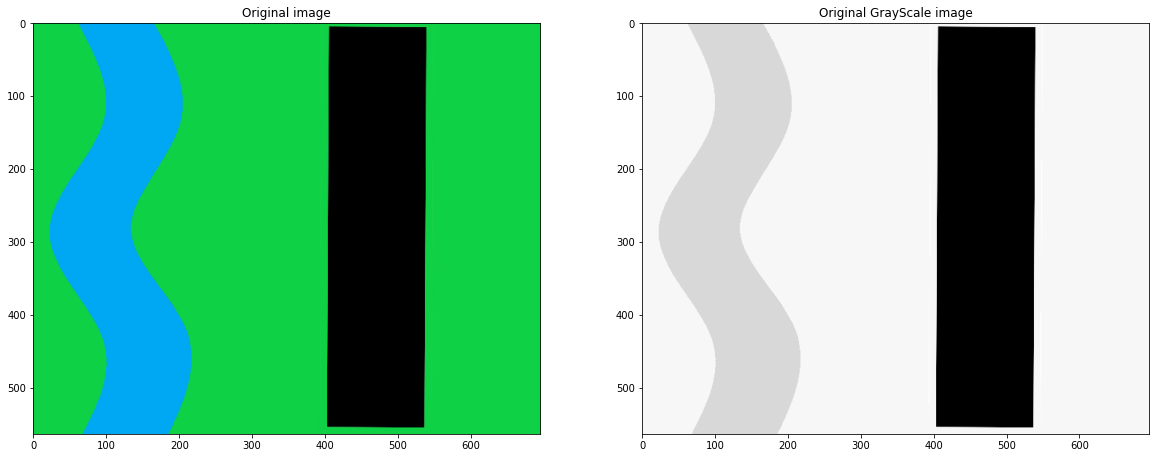

In [26]:
# _img = io.imread('final.png')
_img=io.imread("img1.png")
# use the below line if internet is not available and comment the above line

# _img = imread('riv1.png') 
# _img=io.imread("im.png")

figure(figsize=(20,17))

subplot(1,2,1)
title("Original image")
imshow(_img, cmap="gray")
img = _img
if(len(_img.shape) == 3):
    img = rgb2gray(_img)
    img = img*255

subplot(1,2,2)
title("Original GrayScale image")
imshow(img, cmap="gray")

show()

## Edge detection
#### In this step we try to detect the edges of the image using the Sobel and Canny edge detector.

<hr>


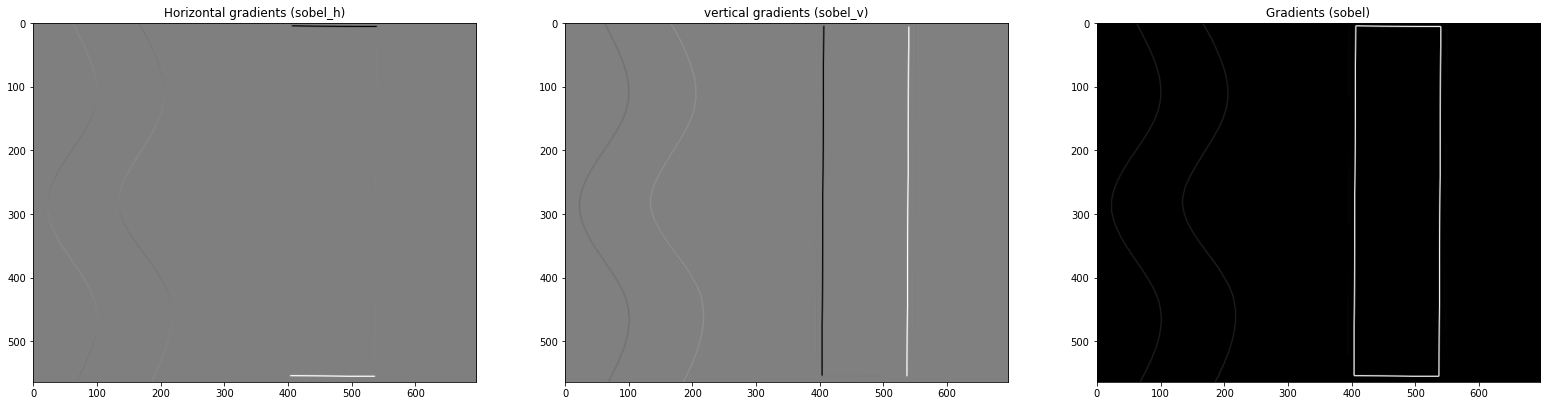

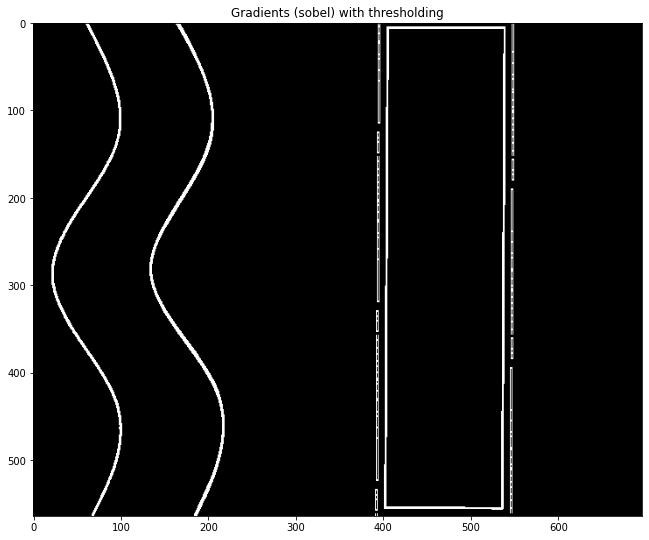

In [27]:
figure(figsize=(27,15))

subplot(2,3,1)
imshow(sobel_h(img), cmap="gray")
title("Horizontal gradients (sobel_h)")

subplot(2,3,2)
imshow(sobel_v(img), cmap="gray")
title("vertical gradients (sobel_v)")

subplot(2,3,3)
imshow(sobel(img), cmap="gray")
title("Gradients (sobel)")

figure(figsize=(24,17))
subplot(1,2,1)

temp = sobel(img)
for(i,j) in zip(*np.where(temp > 0.04)):
    temp[i][j] = 1

imshow(temp, cmap="gray")
title("Gradients (sobel) with thresholding")

show()


* NOTE :  An edge detection algorithm (e.g. sobel filter) does not actually "*detect*" edges, it rather "*strengthens*" regions with large changes (edges), and "*weakens*" regions with low changes. After that you can "*extract*" edges by applying some sort of threshold. The result would be a binary image
<hr>

In [28]:
def binImg(img, x, y):
    img2 = np.copy(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] > x and img[i,j] < y:
                img2[i,j] = 255
            else:
                img2[i,j] = 0
    return img2

# masking 3*3
def masking(_img, kernel):
    # wraping the image
    m, n = _img.shape
    img = np.zeros((m + 2, n + 2))
    img[1:m + 1, 1:n + 1] = _img

    m,n = img.shape
    
    img2 = img.copy()
    
    for i in range(m - 2):
        for j in range(n - 2):
            img2[i + 1, j + 1] = np.sum(img[i:i + 3, j:j + 3] * kernel)
    # # img2 = img2.astype(np.uint8)
    
    # # imshow(img2, cmap = 'gray')
    # img2[0, :] = 0
    # img2[m - 1, :] = 0
    # img2[:, 0] = 0
    # img2[:, n - 1] = 0
    return img2[1:m - 1, 1:n - 1]
# masks
avg = np.array([[1, 1, 1], [1, 2, 1], [1, 1, 1]]) / 10
laplacian = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
gaussian = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobely = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
prewittx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitty = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

def sobel_edge(img):
    return np.sqrt(masking(img, sobelx)**2 + masking(img, sobely)**2)
mImg = binImg( masking(img, avg), 70, 100)

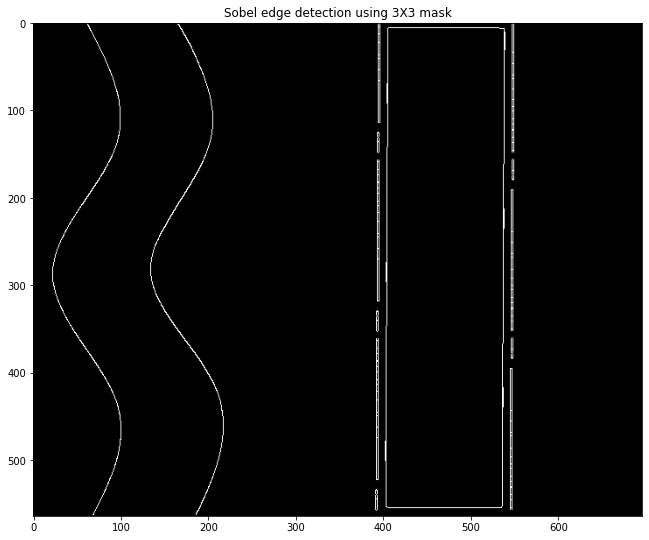

In [37]:
# imgSobel = binImg(sobel(masking(img,avg))*255)
# imgSobel = binImg(masking(img,gau),65,95)
imgSobel = canny(img,)

figure(figsize=(24,17))

subplot(1,2,1)
title("Sobel edge detection using 3X3 mask")
imshow(imgSobel, cmap="gray")

# imgSobel = binImg( sobel_edge(img),70)
# # imgSobel = binImg(sobel_edge(masking(img,avg)))
# subplot(1,2,2)
# imshow(imgSobel, cmap="gray")
# title("sobel with thresholding and binarization From skimage")


# show()


> The edges formed by applying convolution kernels to an image can be **thick** edges.<br>
>> Our task of seperating/detecting lines works far better with thinner edges.<br>
>> So we use morphological  erosion to thin the edges.
>  _________________________________________________________________




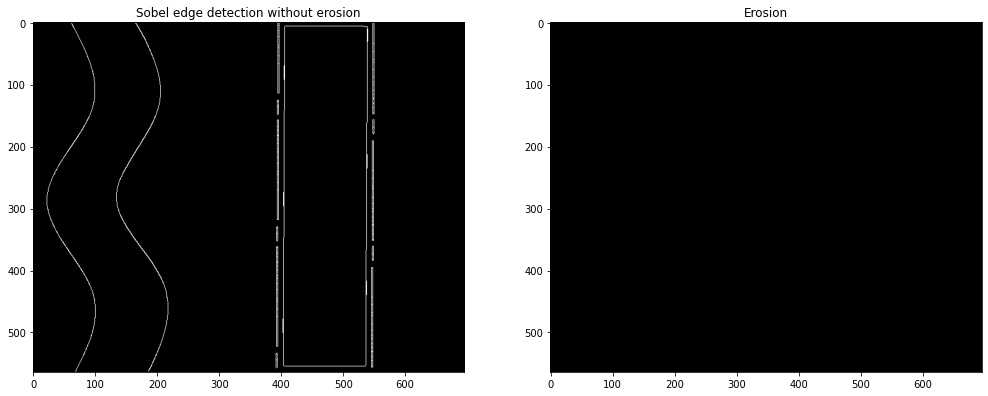

In [38]:
def erosion(img):
    img2 = np.zeros_like(img)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            if img[i, j] == 255:
                if img[i-1, j-1] == 255 and img[i-1, j] == 255 and img[i-1, j+1] == 255 and img[i, j-1] == 255 and img[i, j+1] == 255 and img[i+1, j-1] == 255 and img[i+1, j] == 255 and img[i+1, j+1] == 255:
                    img2[i, j] = 255
    return img2

_imgSobel = erosion(imgSobel.copy())

figure(figsize=(17,14))
subplot(1,2,1)
imshow(imgSobel, cmap="gray")
title("Sobel edge detection without erosion")
subplot(1,2,2)
imshow(_imgSobel, cmap="gray")
title("Erosion")
show()

### Harris corner detection

> Harris corner measure response image.

This corner detector uses information from the auto-correlation matrix A:

    A = [(imx**2)   (imx*imy)] = [Axx Axy]
        [(imx*imy)   (imy**2)]   [Axy Ayy]
Where imx and imy are first derivatives, averaged with a gaussian filter. The corner measure is then defined as:

    det(A) - k * trace(A)**2
> Here we find corners by finding points where intensity transitions take place in two directions.

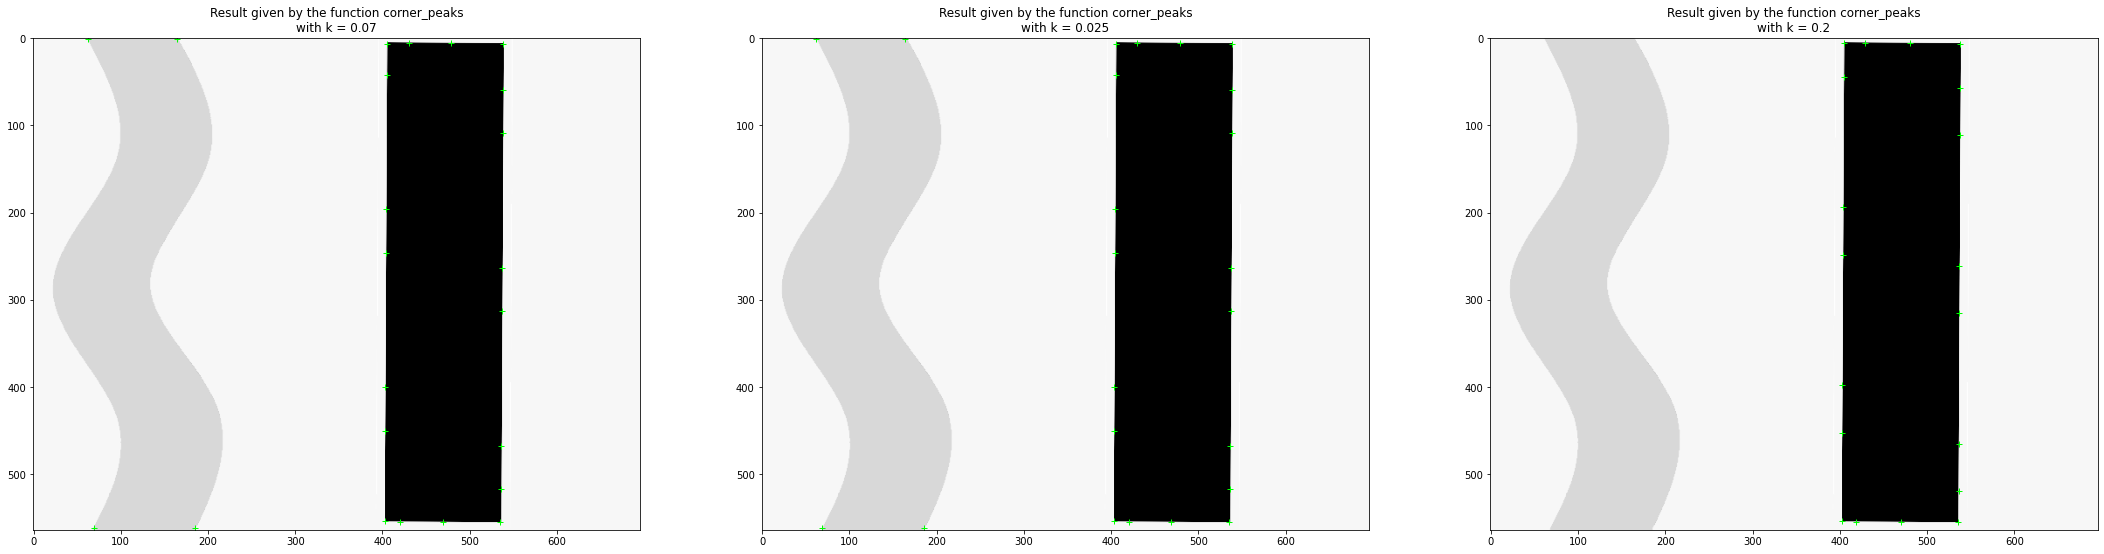

In [31]:
ks = [.07, 0.025, 0.2]

figure(figsize=(37,25))
for i, k in enumerate(ks):
    
    y = corner_harris(imgSobel, method='k', k=k, sigma=2)
    coords = corner_peaks(y, threshold_rel=.1)   
    subplot(1,3,i+1)
    imshow(img, cmap="gray")
    plot(coords[:,1], coords[:,0], color='lime', marker='+', linestyle='none')
    title(f"Result given by the function corner_peaks\nwith k = {k}")


### Hough's Transform

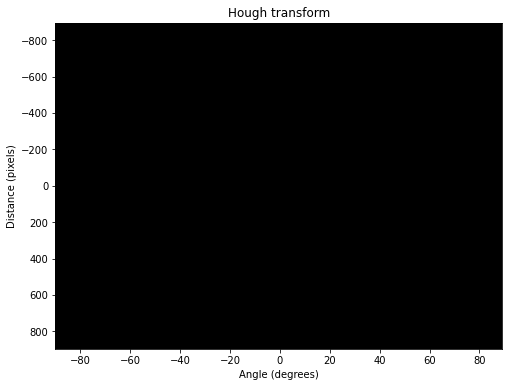

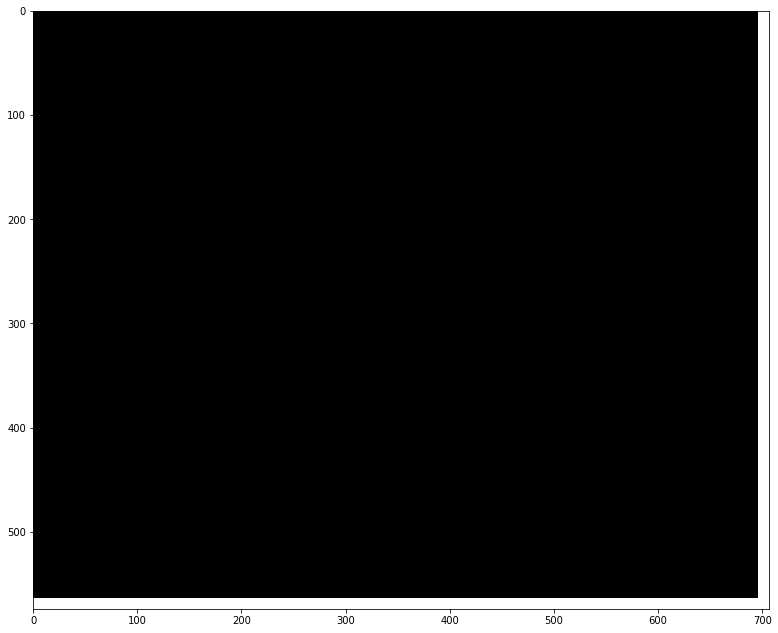

In [32]:
# print(y)


# y = canny(masking(img, gaussian), sigma=2)
y = _imgSobel.copy()/255

accumulator, angle, dist = hough_line(y)

peaks, angles, dists = hough_line_peaks(
    accumulator, angle, dist, threshold=.2*accumulator.max(), num_peaks=4)

# print(peaks, angles, dists)

axes = (rad2deg(angle[0]), rad2deg(angle[-1]), dist[-1], dist[0])

figure(figsize=(8, 6))

imshow(accumulator**.5, cmap="gray", extent=axes, aspect="auto")
xlabel('Angle (degrees)')
ylabel('Distance (pixels)')
title("Hough transform")
plot(rad2deg(angles), dists, marker='o', markeredgecolor='lime',
     markerfacecolor="none", linestyle="none")

show()

M, N = img.shape

figure(figsize=(14, 11))
imshow(y, cmap="gray")

for _, angle, dist in zip(peaks, angles, dists):

    x0 = 0
    y0 = dist / (sin(angle)+0.00000001)
    x1 = N
    y1 = (dist - x1*cos(angle)) / (sin(angle)+0.00000001)

    plot((x0, x1), (y0, y1), color='lime')

axis((0, N+10, M+10, 0))
show()


> ### Probabilistic Hough Transform for straight line detection

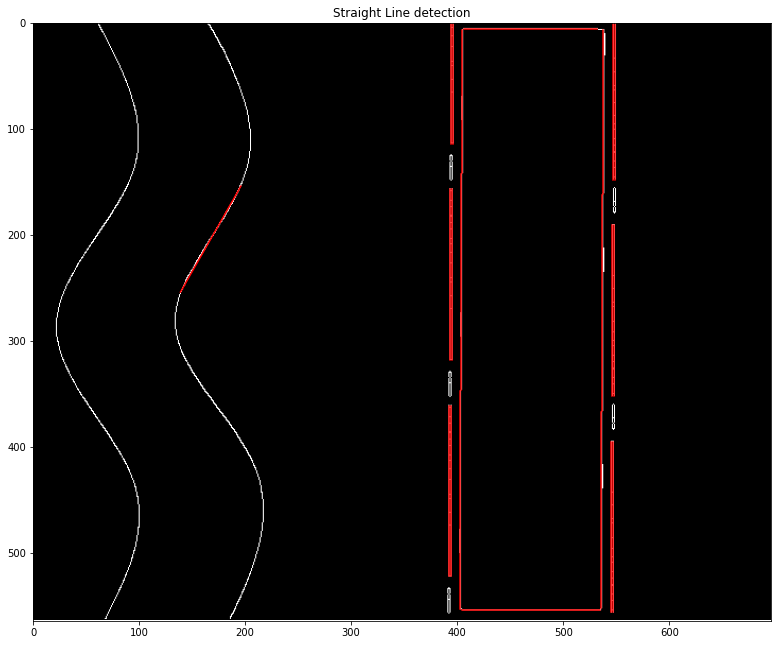

In [33]:
temp = (canny(img))
# temp = _imgSobel.copy()/255

N,M = temp.shape
lines = probabilistic_hough_line(temp, threshold=86, line_length=80, line_gap=3)
figure(figsize=(14,11))
imshow(temp,cmap="gray")

for line in lines:
    p0, p1 = line
    plot((p0[0], p1[0]), (p0[1], p1[1]), color='r')

axis((0,M,N,0))
title("Straight Line detection")
show()

## Curve detection 
> In theorey Hough transform  can be used to detect any type of curves, but to detect any curve(other than straight lines) becomes computionally expensive and impractical.<br>
> To detect curved objects in an image we will be using a counter intutive method. We will find all straight lines in the image and push them into the background using floodfill algorithm.<br><hr>

In [34]:
def floodfill12(img, x, y):
    if x>=0 and x<img.shape[0] and y>=0 and y<img.shape[1]:
        if img[x,y] == True:
            img[x,y] = False
        # print("for")
        if x+1 < img.shape[0] and y-1 >= 0:
            floodfill12(img, x+1, y-1)
        if x+1 < img.shape[0] and y+1 < img.shape[1]:
            floodfill12(img, x+1, y+1)
        if x-1 >= 0 and y-1 >= 0:
            floodfill12(img, x-1, y-1)
        if x-1 >= 0 and y+1 < img.shape[1]:
            floodfill12(img, x-1, y+1)
        if x+1 < img.shape[0]:
            floodfill12(img, x+1, y)
        if x-1 >= 0:
            floodfill12(img, x-1, y)
        if y+1 < img.shape[1]:
            floodfill12(img, x, y+1)
        if y-1 >= 0:
            floodfill12(img, x, y-1)
        
        # x = x
    return img


#### Using recursive floodfill caused python kernel to die, it happened due to overflow of system's recursive stack. We are using iterative floodfill to complete the task.

In [35]:
def floodFill(image, sr: int, sc: int):
    color = True
    newColor = False
    if color == newColor:
        return image

    stack = [(sr, sc)]
    while stack:
        x, y = stack.pop()
        if image[x][y] != color:
            continue

        image[x][y] = newColor

        if x > 0:
            stack.append((x-1, y))
        if y > 0:
            stack.append((x, y-1))
        if x < len(image)-1:
            stack.append((x+1, y))
        if y < len(image[0])-1:
            stack.append((x, y+1))
        if x > 0 and y > 0:
            stack.append((x-1, y-1))
        if x > 0 and y < len(image[0])-1:
            stack.append((x-1, y+1))
        if x < len(image)-1 and y > 0:
            stack.append((x+1, y-1))
        if x < len(image)-1 and y < len(image[0])-1:
            stack.append((x+1, y+1))

    return image


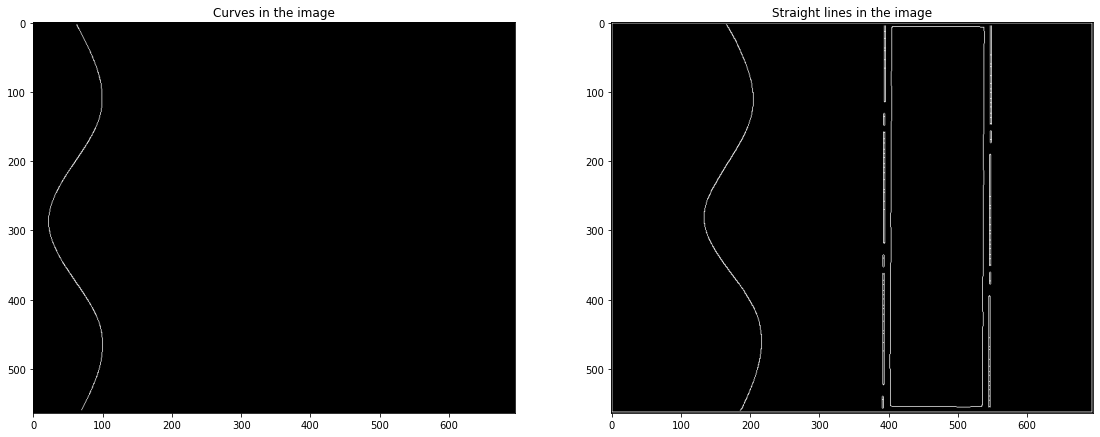

In [36]:
temp = (canny(masking(img, gaussian)))
# temp = _imgSobel.copy()/255
for line in lines:
    p0, p1 = line
    # print(p0, p1)
    M, N = temp.shape
    for i in range(p0[0]-3, p0[0]+3):
        for j in range(p0[1]-3, p0[1]+3):
            if i>=0 and i<N and j>=0 and j<M:
                if temp[j,i] == True:
                    floodFill(temp, j, i)
                    break
    
    for i in range(p1[0]-13, p1[0]+13):
        for j in range(p1[1]-3, p1[1]+3):
            if i>=0 and i<temp.shape[1] and j>=0 and j<temp.shape[0] and temp[j,i] == True:
                floodFill(temp, j, i)
                break

# plot(i, j, color='red', marker='+', linestyle='none')
# axis((0,M,N,0))
figure(figsize=(19,14))
subplot(1,2,1)
imshow(temp, cmap="gray")
title("Curves in the image")

straight = canny(masking(img, gaussian)) ^ temp
subplot(1,2,2)
imshow(straight, cmap="gray")
title("Straight lines in the image")

show()

> Made by
> 1. Keshav Gupta (10067)
> 2. Kapish Gupta (10307)
> 3. Ram Addepalli Pavan Kumar (10308)
> 4. Vaibhav Balaji (10423)
> 5. Tushar Surana (10567)
> <hr>